# TM10007 Assignment template

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [0]:
# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn import svm
from sklearn import preprocessing

# Data loading and cleaning

Some functions

In [0]:
# Some functions we will use
from sklearn.decomposition import PCA

def colorplot(clf, ax, x, y, h=100):
    '''
    Overlay the decision areas as colors in an axes.
    
    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    if len(Z.shape) > 1:
        Z = Z[:, 1]
    
    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm



Data loading and handling missing data. 

In [9]:
# Data loading functions. 
from adni.load_data import load_data 

data = load_data()
print(data.head())
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
#data_missing = data.isnull()
#print(data_missing.index[data_missing == True])

# Creating vector of labels
data_no_label = data.drop(columns='label')
print(f'The number of features: {len(data_no_label.columns)}')
x = data_no_label.values
y = data['label'].values

# Split data
X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3)

# Check if there is missing data in our dataset
x_nan = np.isnan(X_train)
print(f'The number of found NaN is: {np.sum(x_nan)}')
x_zero = np.where(X_train == 0)[0]
print(f'The number of found zeros is: {len(x_zero)}')

# Remove features with almost only zeros
data_no_label = data.drop(columns=['phasef_phasecong_median_WL3_N5', 'phasef_phasecong_min_WL3_N5', 'phasef_phasecong_quartile_range_WL3_N5', 'phasef_phasesym_median_WL3_N5', 'phasef_phasesym_min_WL3_N5', 'phasef_phasesym_quartile_range_WL3_N5'])
print(f'The number of features after exclusion is: {len(data_no_label.columns)}')
x = data_no_label.values
x_zero = np.where(X_train == 0)[0]
print(f'The number of found zeros after feature exclusion is: {len(x_zero)}')

# In deze features komen bij sommige samples 0'en of gekke getallen voor
#   - tf_NGTDM_Busyness
#   - tf_NGTDM_Coarseness
#   - tf_NGTDM_Complexity
#   - tf_NGTDM_Contrast
#   - tf_NGTDM_Strength
# Moeten we daar nog iets mee??

                     hf_energy  ...  vf_Frangi_inner_std_SR(1.0, 10.0)_SS2.0
ID                              ...                                         
0_002_S_0413_bl_0  5403.229408  ...                             4.207831e-10
0_002_S_0559_bl_0   922.459760  ...                             3.137258e-10
0_002_S_0619_bl_0  1674.765276  ...                             4.219847e-10
0_002_S_0685_bl_0  3443.797200  ...                             5.954654e-11
0_002_S_0816_bl_0   914.469846  ...                             4.174750e-10

[5 rows x 268 columns]
The number of samples: 855
The number of columns: 268
The number of features: 267
The number of found NaN is: 0
The number of found zeros is: 4336
The number of features after exclusion is: 262
The number of found zeros after feature exclusion is: 4336


# Feature scaling and selection


In [0]:
# Scaling of features
scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)

# Feature selection
# ? Bepalen welke manier van feature selection we willen gebruiken

Code hieronder gebruiken of vervangen.

Feature ranking:
1. feature 1 (0.056905)
2. feature 2 (0.053117)
3. feature 11 (0.031408)
4. feature 8 (0.029132)
5. feature 140 (0.027247)
6. feature 224 (0.026262)
7. feature 105 (0.026101)
8. feature 229 (0.018797)
9. feature 106 (0.016582)
10. feature 117 (0.016565)
11. feature 227 (0.014820)
12. feature 228 (0.012319)
13. feature 119 (0.012012)
14. feature 107 (0.011542)
15. feature 168 (0.011271)
16. feature 118 (0.010590)
17. feature 115 (0.009894)
18. feature 226 (0.009771)
19. feature 79 (0.009052)
20. feature 156 (0.007953)
21. feature 7 (0.007858)
22. feature 230 (0.007735)
23. feature 159 (0.007352)
24. feature 76 (0.007096)
25. feature 113 (0.006926)
26. feature 221 (0.006535)
27. feature 111 (0.006528)
28. feature 171 (0.006356)
29. feature 10 (0.006266)
30. feature 6 (0.005939)
31. feature 212 (0.005861)
32. feature 86 (0.005848)
33. feature 85 (0.005767)
34. feature 161 (0.005693)
35. feature 147 (0.005361)
36. feature 206 (0.005336)
37. feature 78 (0.005305)
38. featur

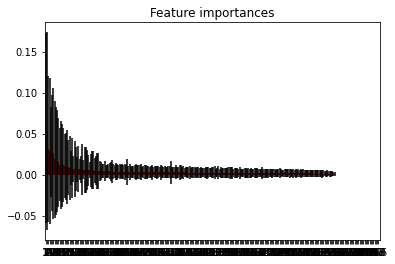

In [11]:


# Split data -> nog niet zeker welke te gebruiken
'''
# Of leave one out
loo = LeaveOneOut()
for train, test in loo.split(x):
  pass
'''

"""
Stukje van Eleen, doet bijna hetzelfde alleen heeft x nog kolomnamen
# Creating vector of labels
x = data.drop('label', axis=1)
y = data['label'].values
print(x)
"""

"""
# Perform PCA -> Niet zeker of we dit nou moeten doen, n_features moet waarschijnlijk iets anders zijn
n_features = len(data_no_label.columns) #ik denk dus dat dit alle features nu behoudt, maar snap nog niet helemaal hoe die PCA werkt
p = PCA(n_components=n_features)
p = p.fit(x)
x = p.transform(x)
"""

# Build a forest and compute the feature importances. Bedenken of dit op training set of volledige set moet
forest = RandomForestClassifier(n_estimators=100)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()